# 기본세팅

In [47]:
### 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 colab의 경우 Runtime > Restart session 필요

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Font directories:
	/root/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/root/.fonts
	/usr/share/fonts/truetype
	/usr/share/fonts/truetype/dejavu
	/usr/share/fonts/truetype/liberation
	/usr/share/fonts/truetype/nanum
/root/.local/share/fonts: skipping, no such directory
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/root/.fonts: skipping, no such directory
/usr/shar

In [48]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용

In [49]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import scipy.stats as stats

# 간병인 플랫폼 어플 리뷰 분석
## 분석 목적 : 레어필드 간병인서비스와 유사한 사업을 운영하고 있는 경쟁업체 플랫폼의 어플 리뷰 분석
- 경쟁업체 분석을 통한 pain point 접근
- 환자용 어플과 간병인용 어플 분류하여 접근

### 분석 방향
1) 경쟁사 어플리케이션 리뷰 환자용/간병인용 분류
1) 경쟁사 어플리케이션 리뷰 긍/부정 분류
2) 긍정 리뷰 keyword 추출
3) 부정 리뷰 keyword 추출 (pain point)
4) 비교 차트 그리기 & 우리 사업의 방향성 제시

#### dataset 불러오기

In [50]:
# mongo에서 db 불러오는 함수
import pymongo
def dbconnect(collection) :
    client=pymongo.MongoClient('mongodb://trainings.iptime.org',45003)
    db= client['data_analysis']
    collection = db[collection]
    data = collection.find()
    df = pd.DataFrame(data)
    return df

In [51]:
# 중복값 제거하는 함수(contents를 기준으로)
def drop_duplicates(df, contents) : 
    df.drop_duplicates(subset=contents, keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [52]:
# 특정 열에서 list를 str으로 변환하는 함수
def list_join(row) :
    row = ' '.join(row)
    return row

In [53]:
# 특정 열에서 \n 삭제하는 함수
def remove_text(row):
    if pd.notnull(row):
        row = row.replace(r'\n', ' ')
    return row

In [187]:
# 구글 플레이스토어 리뷰 불러오기
df_googlestore = dbconnect('caregive_platform_google')
# 애플 앱스토어 리뷰 불러오기
df_applestore = dbconnect('caregive_platform_apple')
# 행으로 데이터프레임 합치기
df_medical_platform = pd.concat([df_googlestore, df_applestore], axis=0)
df_medical_platform

,_id,app_name,user_score,user_date,user_comments,evaluation
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,3
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",14
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,13
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음,2
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,
...,...,...,...,...,...,...
167,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요,0
168,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요,0
169,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...,0
170,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...,0


In [188]:
df_applestore

,_id,app_name,user_score,user_date,user_comments,evaluation
0,664abe7e5d1ec9ef48bece73,케어닥,1,2024-01-04T22:11:47-07:00,단순 간병인만 구하기 쉬운 앱\n큰와병이 아니라면 간병인은 잘 구해짐. 경쟁사보다 ...,0
1,664abe7e5d1ec9ef48bece74,케어닥,5,2023-12-29T07:42:52-07:00,30일부터 시작일로 나흘동안 기간을 잡고 \n결제하고 번호는 왜 뜨게해놨나요 진작에...,0
2,664abe7e5d1ec9ef48bece75,케어닥,3,2023-10-31T20:23:59-07:00,업데이트 하라고만 계속 뜨고 앱 실행이 안됩니다,0
3,664abe7e5d1ec9ef48bece76,케어닥,1,2023-08-13T07:23:16-07:00,낙상시켜서 피멍들기하고 아무것고 한거 없으면서 못하겠다거 힘들다고 징징거리고 대놓고...,0
4,664abe7e5d1ec9ef48bece77,케어닥,3,2023-02-16T20:53:21-07:00,처음에 간병 서비스 신청 하고 나서\n나중에 신청서 수정 > 맨 하단에 특이사항 적...,0
...,...,...,...,...,...,...
167,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요,0
168,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요,0
169,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...,0
170,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...,0


#### data 전처리

In [189]:
df_medical_platform.isnull().sum()

_id              0
app_name         0
user_score       0
user_date        0
user_comments    0
evaluation       0
dtype: int64

In [190]:
del df_medical_platform['evaluation']
df_medical_platform

,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
167,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요
168,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요
169,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...
170,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...


#### 분석 진행

##### 1. 경쟁사 어플리케이션 리뷰 환자용/간병인용 분류

In [191]:
df_medical_platform['app_name'].value_counts()

app_name
케어네이션                            1843
케어네이션(간병인용)                       928
좋은케어                              488
또하나의가족                            110
케어닥                               100
병원잡                                55
간병 나이팅게일                           42
토닥씨                                35
좋은 케어                              20
이웃하다                               17
케어파트너 요양보호사 장기요양 구직 취업 일자리 찾기      15
헬퍼                                 11
케어링크                               11
케어플러스                               9
헬로우케어                               6
캐어매치                                5
따뜻한돌봄                               4
Name: count, dtype: int64

In [192]:
# 환자용 
df_medical_platform_patient = df_medical_platform[df_medical_platform['app_name'].isin(['케어닥', '케어네이션', '헬퍼', '케어플러스', '이웃하다', '좋은 케어', '간병 나이팅게일', '또하나의가족', '헬로우케어', '토닥씨'])]
df_medical_platform_patient

,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
167,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요
168,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요
169,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...
170,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...


In [193]:
# 간병인용 
df_medical_platform_caremanager = df_medical_platform[df_medical_platform['app_name'].isin(['케어닥', '케어네이션(간병인용)', '헬퍼', '케어링크', '케어매치', '케어파트너 요양보호사 장기요양 구직 취업 일자리 찾기', '병원잡'])]
df_medical_platform_caremanager

,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
137,664abf095d1ec9ef48becefc,병원잡,3,2020-12-02T19:22:26-07:00,렉도 없고 항상 공고가 올라와서 너무 좋은 것 같아요!
138,664abf095d1ec9ef48becefd,병원잡,5,2020-11-27T04:03:45-07:00,이곳저곳 알아 보기 힘들 때 병원잡 어플 하나면\n한눈에 다 알아보고 일자리 구할 ...
139,664abf095d1ec9ef48becefe,병원잡,5,2020-11-07T23:03:57-07:00,한눈에 빠르게 전국 병원의 구인을 볼수 있어서 좋네요\n이력서 등록해 두면 편리 합니다
140,664abf095d1ec9ef48beceff,병원잡,4,2020-11-04T22:19:43-07:00,공고 한눈에 보기 좋아서 편리해요


##### 2. 경쟁사 어플리케이션 리뷰 긍부정 분류 (환자용 경쟁사 어플리케이션 리뷰 분석)

###### data 전처리

In [194]:
df_medical_platform_patient

,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
167,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요
168,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요
169,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...
170,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...


In [195]:
drop_duplicates(df_medical_platform_patient, 'user_comments')

/tmp/ipykernel_135/3758560691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=contents, keep='first', inplace=True)


,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
2180,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요
2181,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요
2182,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...
2183,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...


In [196]:
df_medical_platform_patient.loc[:,'user_comments'] = df_medical_platform_patient['user_comments'].apply(remove_text)
df_medical_platform_patient

,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
2180,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요
2181,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요
2182,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...
2183,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...


###### 형태소 분석기

###### mecab

In [197]:
# 숫자 삭제
df_medical_platform_patient['user_comments'] = df_medical_platform_patient['user_comments'].str.replace('[0-9]','',regex=True)
df_medical_platform_patient

/tmp/ipykernel_135/1831006853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_patient['user_comments'] = df_medical_platform_patient['user_comments'].str.replace('[0-9]','',regex=True)


,_id,app_name,user_score,user_date,user_comments
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠..."
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
...,...,...,...,...,...
2180,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요
2181,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요
2182,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...
2183,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...


In [198]:
!pip install python-mecab-ko

In [199]:
from mecab import MeCab
mecab = MeCab()

In [200]:
mecab.pos(df_medical_platform_patient['user_comments'][0])

[('오늘', 'MAG'),
 ('갑자기', 'MAG'),
 ('에러', 'NNG'),
 ('가', 'JKS'),
 ('자꾸', 'MAG'),
 ('뜨', 'VV'),
 ('네요', 'EF'),
 ('글구', 'MAJ'),
 ('보', 'VV'),
 ('고', 'EC'),
 ('있', 'VX'),
 ('던', 'ETM'),
 ('창', 'NNG'),
 ('이', 'JKS'),
 ('유지', 'NNG'),
 ('가', 'JKS'),
 ('되', 'VV'),
 ('지', 'EC'),
 ('않', 'VX'),
 ('고', 'EC'),
 ('나갔', 'VV+EP'),
 ('다', 'EC'),
 ('들어오', 'VV'),
 ('면', 'EC'),
 ('처음', 'NNG'),
 ('으로', 'JKB'),
 ('돌아와서', 'VV+EC'),
 ('재', 'XPN'),
 ('부팅', 'NNG'),
 ('되', 'XSV'),
 ('는', 'ETM'),
 ('점', 'NNG'),
 ('개선', 'NNG'),
 ('되', 'XSV'),
 ('었', 'EP'),
 ('음', 'ETN'),
 ('좋', 'VA'),
 ('겠', 'EP'),
 ('네요', 'EF'),
 ('사용', 'NNG'),
 ('하', 'XSV'),
 ('기', 'ETN'),
 ('불편', 'NNG'),
 ('하', 'XSA'),
 ('고', 'EC'),
 ('매칭', 'NNP'),
 ('전혀', 'MAG'),
 ('안', 'MAG'),
 ('되', 'VV'),
 ('네요', 'EF'),
 ('ㅠ', 'UNKNOWN')]

In [201]:
def mecab_tag(text):
    morphs_nouns = []
    morphs_nouns_list = []
    for sentence in text:
        # 명사, 형용사, 동사
        morphs = [morph for morph, tag in mecab.pos(sentence) if tag in ['VV+ETN', 'MM', 'NNG', 'NNP', 'NP', 'NR', 'VA', 'VV']]
        morphs_nouns.append(' '.join(morphs))
    
    return morphs_nouns

In [202]:
df_medical_platform_patient.isnull().sum()

_id              0
app_name         0
user_score       0
user_date        0
user_comments    0
dtype: int64

In [203]:
morphs_nouns = mecab_tag(df_medical_platform_patient['user_comments'])

In [204]:
df_medical_platform_patient['review_clean_mecab'] = morphs_nouns

/tmp/ipykernel_135/164764511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_patient['review_clean_mecab'] = morphs_nouns


In [205]:
df_medical_platform_patient

,_id,app_name,user_score,user_date,user_comments,review_clean_mecab
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 처음 부팅 점 개선 좋 사용 불편 매칭 되
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레이드 맘 간 병비 싸 지역 나누 병원 재가 좋
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,편리 실용
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음,입주 경력 많
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,정보 제공 감사
...,...,...,...,...,...,...
2180,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요,요양 병원 정보 필요 앱 있 좋
2181,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요,앱 편하 상담 받 있 편하 조아
2182,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...,가 다른 사이트 정보 많 요양원 찾 때 이용 들어가 플 하 플 없 플 쓰 좋
2183,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...,입소 관련 상담 답변 빠르 친절 동네 있 시설 있 사용


In [206]:
df_medical_platform_patient.query('review_clean_mecab == ""')

,_id,app_name,user_score,user_date,user_comments,review_clean_mecab
40,66473d760f1921e26da151db,케어닥,1,2022년 6월 14일,별로^^,
41,66473d760f1921e26da151dc,케어닥,4,2021년 7월 19일,. .,
42,66473d760f1921e26da151de,케어닥,5,2021년 4월 30일,Good,
805,66473ec99eb467927105560b,케어네이션,5,2021년 11월 11일,너무 잘해주시는데 이렇게 잘해주시는 분이 또 계실까 싶습니다,
1599,66473efa9eb4679271055926,케어네이션,5,2021년 6월 1일,너무 편해요,
1648,66473efd9eb4679271055957,케어네이션,1,2021년 11월 12일,그냥 그냥 무난무난,
1732,66473f019eb46792710559ab,케어네이션,5,2024년 4월 1일,편해요~,
1814,66473f069eb46792710559fd,케어네이션,4,2023년 12월 27일,너무복잡해요.,
1831,66473f079eb4679271055a11,케어네이션,5,2021년 12월 11일,너무 땡큐합니다!!,
1833,66473f079eb4679271055a13,케어네이션,5,2021년 8월 30일,잘 썻습니다,


###### okt

In [207]:
!pip install konlpy

In [208]:
from konlpy.tag import Okt
okt = Okt()

In [209]:
# 조사, 어미, 구두점 같은 것을 제거
def okt_clean(text):
    clean_text = []
    for word in okt.pos(text, stem=True):
        if word[1] not in ['Josa', 'Eomi', 'Punctuation', 'Adverb', 'Suffix', 'KoreanParticle', 'Alpha', 'Verb']:
            clean_text.append(word[0])

    return " ".join(clean_text)

In [210]:
df_medical_platform_patient['review_clean_okt'] = df_medical_platform_patient['user_comments'].apply(okt_clean)

/tmp/ipykernel_135/3223985438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_patient['review_clean_okt'] = df_medical_platform_patient['user_comments'].apply(okt_clean)


In [211]:
df_medical_platform_patient['review_clean_okt'][11260:11270]

Series([], Name: review_clean_okt, dtype: object)

In [212]:
okt.pos(df_medical_platform_patient['review_clean_okt'][10])

[('케어', 'Noun'),
 ('닥', 'Noun'),
 ('일자리', 'Noun'),
 ('있다', 'Adjective'),
 ('같다', 'Adjective'),
 ('항상', 'Noun'),
 ('필요하다', 'Adjective'),
 ('사람', 'Noun'),
 ('도움', 'Noun'),
 ('좋다', 'Adjective'),
 ('일자리', 'Noun'),
 ('케어', 'Noun'),
 ('닥', 'Noun'),
 ('번창', 'Noun')]

In [603]:
# 문장 정리 및 재정제
def solve_text(text):
    change_dict = {
        '애러' : '에러'
        , '업그레드' : '업그레이드'
    }
    for i in change_dict:
        text = text.replace(i,change_dict[i])
    return text

In [604]:
df_medical_platform_patient

,_id,app_name,user_score,user_date,user_comments,review_clean_mecab,review_clean_okt
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 부팅 점 개선 좋 불편 매칭 되,오늘 갑자기 에러 자꾸 글 창 유지 재부팅 점 개선 불 매칭 전혀
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레드 맘 간 병비 싸 지역 나누 병원 재가 좋,업그레드 맘 듭니 비도 지역별 병원 재 가도 😠😠😠👊👊👊👊👊
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,편리 실용,간단하다 편리하다 실용 다
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음,입주 경력 많,다 경력
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,정보 공,알차다 정보 공 참으로
...,...,...,...,...,...,...,...
2180,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요,요양 병원 정보 필요 있 좋,요양 병원 정보 필요하다 간
2181,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요,편하 상담 받 있 편하 조아,바로 상담
2182,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...,가 사트 정보 많 요양원 찾 들어가 플 하 플 없 플 쓰 좋,또 가가 사트 정보 보기 요양원 \n 아쉽다 \n \n 쓰기
2183,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...,입소 관련 상담 답변 빠르 친절 동네 있 시설 있,입소 관련 상담 답변 빠르다 친절하다 동네 시설


In [605]:
df_medical_platform_patient.query('review_clean_okt == ""')

,_id,app_name,user_score,user_date,user_comments,review_clean_mecab,review_clean_okt
39,66473d760f1921e26da151da,케어닥,4,2023년 1월 29일,좋아요,좋,
41,66473d760f1921e26da151dc,케어닥,4,2021년 7월 19일,. .,,
42,66473d760f1921e26da151de,케어닥,5,2021년 4월 30일,Good,,
1230,66473ee09eb46792710557b4,케어네이션,5,2021년 5월 8일,간병인 잘구했습니다~~~~~~,,
1334,66473eeb9eb467927105581d,케어네이션,5,2021년 5월 31일,잘 연결된듯합니다~ 감사합니다^^,,
1563,66473ef89eb4679271055902,케어네이션,5,2021년 4월 7일,간병인분 감사했습니다.,,
1582,66473ef99eb4679271055915,케어네이션,5,2021년 11월 13일,잘해주셔서 감사해요,,
1599,66473efa9eb4679271055926,케어네이션,5,2021년 6월 1일,너무 편해요,,
1651,66473efd9eb467927105595a,케어네이션,1,2021년 8월 14일,뭐라 남길말이 없음,뭐 말 없,
1652,66473efd9eb467927105595b,케어네이션,4,2021년 8월 14일,감사해요~,,


In [638]:
# 어플명 제거
import re

pattern = '문|아니다|환자|보호자|왜|결|모든|진짜|그냥|되다|조금|자꾸만|그런|아폰|보튼|다시|한개|네트워크|연결|자주|렇다|다른|다음|여러|고맙다|여기|시간|캐어닥|닥|제|때|일|처음|후기더|잘|보고|편하다|사용|이용|이|안|분|많다|것|네이션|어플|없다|인|구|수|앱|있다|센터|고객|간병|간병인|좋다|정말|덕분|케어|같다|서비스|감사|케어닥|케어네이션(간병인용)|헬퍼|케어링크|케어매치|케어파트너요양보호사장기요양구직취업일자리찾기|병원잡|케어플러스|이웃하다|좋은케어|간병나이팅게일|또하나의가족|헬로우케어|토닥씨'
df_medical_platform_patient['review_clean_mecab'] = df_medical_platform_patient['review_clean_mecab'].str.replace(pattern, '', regex=True)
df_medical_platform_patient['review_clean_okt'] = df_medical_platform_patient['review_clean_okt'].str.replace(pattern, '', regex=True)

/tmp/ipykernel_135/205087665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_patient['review_clean_mecab'] = df_medical_platform_patient['review_clean_mecab'].str.replace(pattern, '', regex=True)
/tmp/ipykernel_135/205087665.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_platform_patient['review_clean_okt'] = df_medical_platform_patient['review_clean_okt'].str.replace(pattern, '', regex=True)


In [639]:
df_medical_platform_patient

,_id,app_name,user_score,user_date,user_comments,review_clean_mecab,review_clean_okt
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 부팅 점 개선 좋 불편 매칭 되,오늘 갑자기 에러 자꾸 글 창 유지 재부팅 점 개선 불 매칭 전혀
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레드 맘 간 병비 싸 지역 나누 병원 재가 좋,업그레드 맘 듭니 비도 지역별 병원 재 가도 😠😠😠👊👊👊👊👊
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,편리 실용,간단하다 편리하다 실용 다
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음,입주 경력 많,다 경력
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,정보 공,알차다 정보 공 참으로
...,...,...,...,...,...,...,...
2180,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요,요양 병원 정보 필요 있 좋,요양 병원 정보 필요하다 간
2181,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요,편하 상담 받 있 편하 조아,바로 상담
2182,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...,가 사트 정보 많 요양원 찾 들어가 플 하 플 없 플 쓰 좋,또 가가 사트 정보 보기 요양원 \n 아쉽다 \n \n 쓰기
2183,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...,입소 관련 상담 답변 빠르 친절 동네 있 시설 있,입소 관련 상담 답변 빠르다 친절하다 동네 시설


###### okt로 선택

In [640]:
df_medical_platform_patient

,_id,app_name,user_score,user_date,user_comments,review_clean_mecab,review_clean_okt
0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 부팅 점 개선 좋 불편 매칭 되,오늘 갑자기 에러 자꾸 글 창 유지 재부팅 점 개선 불 매칭 전혀
1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레드 맘 간 병비 싸 지역 나누 병원 재가 좋,업그레드 맘 듭니 비도 지역별 병원 재 가도 😠😠😠👊👊👊👊👊
2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,편리 실용,간단하다 편리하다 실용 다
3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음,입주 경력 많,다 경력
4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,정보 공,알차다 정보 공 참으로
...,...,...,...,...,...,...,...
2180,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요,요양 병원 정보 필요 있 좋,요양 병원 정보 필요하다 간
2181,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요,편하 상담 받 있 편하 조아,바로 상담
2182,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...,가 사트 정보 많 요양원 찾 들어가 플 하 플 없 플 쓰 좋,또 가가 사트 정보 보기 요양원 \n 아쉽다 \n \n 쓰기
2183,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...,입소 관련 상담 답변 빠르 친절 동네 있 시설 있,입소 관련 상담 답변 빠르다 친절하다 동네 시설


In [641]:
df_medical_platform_patient.isin(['']).sum()

_id                    0
app_name               0
user_score             0
user_date              0
user_comments          0
review_clean_mecab    26
review_clean_okt      22
dtype: int64

In [642]:
df_appreview_okt = df_medical_platform_patient.copy()

In [643]:
df_appreview_okt.replace({'': np.nan}, inplace=True)

In [644]:
df_appreview_okt.dropna(subset=['review_clean_okt'], inplace=True)

In [645]:
df_appreview_okt.isin(['']).sum()

_id                   0
app_name              0
user_score            0
user_date             0
user_comments         0
review_clean_mecab    0
review_clean_okt      0
dtype: int64

In [646]:
df_appreview_okt = df_appreview_okt.reset_index()

###### LDA Keyword 추출

In [647]:
df_appreview_okt

,index,_id,app_name,user_score,user_date,user_comments,review_clean_mecab,review_clean_okt
0,0,66473d740f1921e26da151b3,케어닥,3,2024년 1월 24일,오늘 갑자기 에러가 자꾸 뜨네요 글구 보고 있던 창이 유지가 되지 않고 나갔다 들어...,에러 뜨 보 창 유지 되 들어오 부팅 점 개선 좋 불편 매칭 되,오늘 갑자기 에러 자꾸 글 창 유지 재부팅 점 개선 불 매칭 전혀
1,1,66473d740f1921e26da151b4,케어닥,1,2024년 1월 19일,"업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠...",업그레드 맘 간 병비 싸 지역 나누 병원 재가 좋,업그레드 맘 듭니 비도 지역별 병원 재 가도 😠😠😠👊👊👊👊👊
2,2,66473d740f1921e26da151b5,케어닥,5,2024년 1월 18일,간단하고 편리하며 실용적 입니다.,편리 실용,간단하다 편리하다 실용 다
3,3,66473d740f1921e26da151b6,케어닥,5,2024년 4월 1일,입주경력많음,입주 경력 많,다 경력
4,4,66473d740f1921e26da151b7,케어닥,5,2024년 1월 19일,알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~,정보 공,알차다 정보 공 참으로
...,...,...,...,...,...,...,...,...
2158,2180,664abf0b5d1ec9ef48becf1a,또하나의가족,5,2022-06-26T19:42:24-07:00,요양병원 정보가 필요했는데 앱으로 이렇게 간편하게 찾아볼 수 있어서 넘 좋네요,요양 병원 정보 필요 있 좋,요양 병원 정보 필요하다 간
2159,2181,664abf0b5d1ec9ef48becf1b,또하나의가족,5,2022-06-15T18:11:44-07:00,앱으로 편하게 바로 상담 받을 수 있어 넘 편하고 조아요,편하 상담 받 있 편하 조아,바로 상담
2160,2182,664abf0b5d1ec9ef48becf1c,또하나의가족,5,2022-06-09T03:29:53-07:00,또가가 다른 사이트에 비해 정보도 많고 보기 편해서 \n\n요양원 찾을 때마다 이...,가 사트 정보 많 요양원 찾 들어가 플 하 플 없 플 쓰 좋,또 가가 사트 정보 보기 요양원 \n 아쉽다 \n \n 쓰기
2161,2183,664abf0b5d1ec9ef48becf1d,또하나의가족,4,2022-06-08T01:37:25-07:00,입소 관련해서 상담 드렸는데 답변도 빠르고 친절했어요. 동네에 있는 시설들 다 찾아...,입소 관련 상담 답변 빠르 친절 동네 있 시설 있,입소 관련 상담 답변 빠르다 친절하다 동네 시설


In [648]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

###### 긍정(user_score = 4 & user_score = 5)

In [649]:
df_appreview_okt_positive = df_appreview_okt.query('user_score == "4" or user_score == "5"')

In [650]:
# 텍스트 데이터 전처리 및 벡터화
vectorizer = TfidfVectorizer()
feature_12 = vectorizer.fit_transform(df_appreview_okt_positive['review_clean_okt'])

In [651]:
# LDA 모델 훈련
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(feature_12)

LatentDirichletAllocation(n_components=5, random_state=42)

In [652]:
# 훈련된 LDA 모델로 문서별 토픽 할당
document_topics = lda.transform(feature_12)

# 각 문서의 주요 토픽 확인
for idx, topic in enumerate(document_topics):
    print(f"Document {idx} belongs to Topic {topic.argmax()}")

Document 0 belongs to Topic 0
Document 1 belongs to Topic 0
Document 2 belongs to Topic 1
Document 3 belongs to Topic 1
Document 4 belongs to Topic 0
Document 5 belongs to Topic 0
Document 6 belongs to Topic 2
Document 7 belongs to Topic 0
Document 8 belongs to Topic 4
Document 9 belongs to Topic 2
Document 10 belongs to Topic 4
Document 11 belongs to Topic 2
Document 12 belongs to Topic 2
Document 13 belongs to Topic 4
Document 14 belongs to Topic 2
Document 15 belongs to Topic 1
Document 16 belongs to Topic 0
Document 17 belongs to Topic 4
Document 18 belongs to Topic 1
Document 19 belongs to Topic 4
Document 20 belongs to Topic 2
Document 21 belongs to Topic 0
Document 22 belongs to Topic 2
Document 23 belongs to Topic 1
Document 24 belongs to Topic 3
Document 25 belongs to Topic 2
Document 26 belongs to Topic 2
Document 27 belongs to Topic 0
Document 28 belongs to Topic 0
Document 29 belongs to Topic 0
Document 30 belongs to Topic 1
Document 31 belongs to Topic 3
Document 32 belong

In [653]:
# 토픽 모델링 결과 해석
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    # 토픽별로 상위 단어 10개 출력
    top_word_indices = topic.argsort()[:-10-1:-1]
    top_words = [feature_names[i] for i in top_word_indices if i < len(feature_names)]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: 생각, 엄마, 괜찮다, 힘들다, 가족, 어머니, 경력, 퇴원, 마음, 편리하다
Topic 1: 도움, 필요하다, 급하다, 카드, 정보, 후기, 부담, 빠르다, 걱정, 매칭
Topic 2: 추천, 연장, 유용하다, 어떻다, 비용, 막막하다, 선생님, 다행, 사람, 항상
Topic 3: 친절하다, 만족스럽다, 만족하다, 직접, 추천, 한번, 아버지, 어렵다, 원하다, 주변
Topic 4: 선택, 편리하다, 후기, 가장, 마음, 지원, 보기, 리뷰, 프로필, 찾기


In [654]:
ppositive = ' '.join(df_appreview_okt_positive['review_clean_okt'])
positive_01 = positive.split()
positive_01

['간단하다',
 '편리하다',
 '실용',
 '다',
 '다',
 '경력',
 '알차다',
 '정보',
 '공',
 '참으로',
 '필요하다',
 '관련',
 '자료',
 '접',
 '사실',
 '곳',
 '나하',
 '곳',
 '전화',
 '화면',
 '사소',
 '한',
 '관심',
 '주시',
 '그리고',
 '코디',
 '열심',
 '자리',
 '항상',
 '필요하다',
 '사람',
 '도움',
 '자리',
 '번창',
 '꼭',
 '필요하다',
 '가족',
 '병원',
 '입원',
 '난감하다',
 '유용하다',
 '경험',
 '어르신',
 '내',
 '몸',
 '소중하다',
 '개편',
 '하다',
 '코디',
 '프리미엄',
 '더',
 '상',
 '반',
 '병원',
 '비',
 '저렴하다',
 '코디',
 '운영',
 '급',
 '유치하다',
 '익',
 '창',
 '코디',
 '탈',
 '창립',
 '멤버',
 '로써',
 '허무하다',
 '점점',
 '발전',
 '그날',
 '파팅',
 '자리',
 '찿',
 '자리',
 '스마트',
 '의사소통',
 '진행',
 '스케쥴',
 '마',
 '추어',
 '적정하다',
 '기',
 '대가',
 '취지',
 '연락',
 '유저',
 '아',
 '요강',
 '추',
 '네',
 '요',
 '방문',
 '양사',
 '자리',
 '함',
 '다가',
 '뭔',
 '도',
 '춘천',
 '다',
 '보호자',
 '만족하다',
 '합리',
 '문화',
 '선도',
 '관계자',
 '깊다',
 '자격증',
 '사진',
 '왓칭',
 '대',
 '자',
 '현재',
 '프리',
 '렌',
 '서로',
 '가정방문',
 '요양',
 '원하다',
 '요양원',
 '취업',
 '고함',
 '요양보호사',
 '직',
 '유용하다',
 '굿',
 '김',
 '순애',
 '매번',
 '찾기',
 '답답하다',
 '힘들다',
 '거',
 '보',
 '엄마',
 '그',
 '입원',
 '기간',
 '달라',
 '찾기',


In [655]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [656]:
pip install stylecloud

Note: you may need to restart the kernel to use updated packages.


In [657]:
from wordcloud import WordCloud

In [658]:
from collections import Counter
text_split_count = Counter(positive_01)

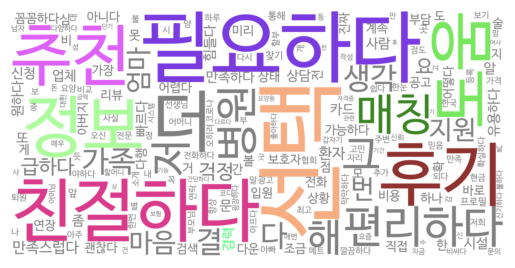

In [659]:
highlighted_words = ["후기", '정보', '선택', '경력', '친절하다', '추천', '도움', '매칭', '필요하다']
import random

def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in highlighted_words:
        hue = random.randint(0, 360)
        saturation = random.randint(50, 100)
        lightness = random.randint(20, 80)
        return "hsl({}, {}%, {}%)".format(hue, saturation, lightness)  # 랜덤 색상
    else:
        return "gray"  # 회색
        
wordCloud = WordCloud(scale=10, color_func=custom_color_func, background_color="white",
                     font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
wordCloud.generate_from_frequencies(text_split_count)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()


###### 긍정 - 별점 4 & 5 점 리뷰 topic
- Topic 0: 생각, 엄마, 괜찮다, 힘들다, 가족, 어머니, 경력, 퇴원, 마음, 편리하다
- Topic 1: 도움, 필요하다, 급하다, 카드, 정보, 후기, 부담, 빠르다, 걱정, 매칭
- Topic 2: 추천, 연장, 유용하다, 어떻다, 비용, 막막하다, 선생님, 다행, 사람, 항상
- Topic 3: 친절하다, 만족스럽다, 만족하다, 직접, 추천, 한번, 아버지, 어렵다, 원하다, 주변
- Topic 4: 선택, 편리하다, 후기, 가장, 마음, 지원, 보기, 리뷰, 프로필, 찾기

주목할 keyword : 후기, 정보, 선택, 도움, 친절, 추천, 경력, 매칭, 필요 등

###### 부정(user_score = 1 & user_score = 2)

In [660]:
df_appreview_okt_negative = df_appreview_okt.query('user_score == "1" or user_score == "2"')

In [661]:
# 텍스트 데이터 전처리 및 벡터화
vectorizer = TfidfVectorizer()
feature_45 = vectorizer.fit_transform(df_appreview_okt_negative['review_clean_okt'])

In [662]:
# LDA 모델 훈련
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(feature_45)

LatentDirichletAllocation(n_components=5, random_state=42)

In [663]:
# 훈련된 LDA 모델로 문서별 토픽 할당
document_topics = lda.transform(feature_45)

# 각 문서의 주요 토픽 확인
for idx, topic in enumerate(document_topics):
    print(f"Document {idx} belongs to Topic {topic.argmax()}")

Document 0 belongs to Topic 0
Document 1 belongs to Topic 2
Document 2 belongs to Topic 3
Document 3 belongs to Topic 4
Document 4 belongs to Topic 2
Document 5 belongs to Topic 1
Document 6 belongs to Topic 4
Document 7 belongs to Topic 2
Document 8 belongs to Topic 2
Document 9 belongs to Topic 1
Document 10 belongs to Topic 1
Document 11 belongs to Topic 2
Document 12 belongs to Topic 2
Document 13 belongs to Topic 4
Document 14 belongs to Topic 1
Document 15 belongs to Topic 1
Document 16 belongs to Topic 0
Document 17 belongs to Topic 2
Document 18 belongs to Topic 1
Document 19 belongs to Topic 3
Document 20 belongs to Topic 4
Document 21 belongs to Topic 4
Document 22 belongs to Topic 0
Document 23 belongs to Topic 2
Document 24 belongs to Topic 0
Document 25 belongs to Topic 4
Document 26 belongs to Topic 3
Document 27 belongs to Topic 0
Document 28 belongs to Topic 0
Document 29 belongs to Topic 2
Document 30 belongs to Topic 0
Document 31 belongs to Topic 1
Document 32 belong

In [664]:
# 토픽 모델링 결과 해석
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    # 토픽별로 상위 단어 10개 출력
    top_word_indices = topic.argsort()[:-10-1:-1]
    top_words = [feature_names[i] for i in top_word_indices if i < len(feature_names)]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: 답답하다, 오류, 연락, 추천, 어렵다, 전화하다, 전화, 설정, 금액, 간호사
Topic 1: 필요하다, 지원, 병원, 설치, 카드, 가입, 자꾸, 입원, 취소, 먹통
Topic 2: 별로, 취소, 전화, 생각, 로그, 교육, 등록, 모두, 설명, 난감하다
Topic 3: 힘들다, 사람, 최악, 정보, 작동, 먹통, 어렵다, 상담, 아프다, 검색
Topic 4: 매칭, 전혀, 계속, 무난, 취소, 병원, 저렴하다, 업체, 나쁘다, 사람


In [665]:
negative = ' '.join(df_appreview_okt_negative['review_clean_okt'])
negative_01 = negative.split()
negative_01

['업그레드',
 '맘',
 '듭니',
 '비도',
 '지역별',
 '병원',
 '재',
 '가도',
 '😠😠😠👊👊👊👊👊',
 '새롭다',
 '발견',
 '다',
 '모두',
 '다',
 '매칭',
 '정보',
 '짜증나다',
 '삭',
 '완전',
 '무용지물',
 '듯',
 '운영',
 '어떻다',
 '공고',
 '단',
 '한',
 '개도',
 '저',
 '탁',
 '그러나',
 '나',
 '나',
 '그게',
 '덥다',
 '그리고',
 '주',
 '중',
 '만',
 '학',
 '나',
 '탁',
 '설치',
 '대기',
 '기',
 '십',
 '번',
 '아',
 '오',
 '매칭',
 '전혀',
 '아쉽다',
 '초보자',
 '다',
 '경',
 '험담',
 '조언',
 '부탁드리다',
 '별로',
 '저',
 '하루',
 '오전',
 '시',
 '오전',
 '시',
 '하루',
 '필요하다',
 '주',
 '전',
 '지원',
 '선택',
 '월',
 '월',
 '오전',
 '시',
 '하루',
 '전',
 '월',
 '오전',
 '시',
 '전화',
 '취소',
 '황당하다',
 '타',
 '항의',
 '취소',
 '자기',
 '카',
 '어떻다',
 '내',
 '재',
 '등록',
 '하라',
 '다르다',
 '어처니',
 '내',
 '엉망',
 '하루',
 '동',
 '어떻다',
 '해',
 '야하다',
 '난감하다',
 '전날',
 '당',
 '날',
 '약속',
 '취소',
 '거나',
 '런',
 '발생',
 '가족',
 '피해',
 '속무책',
 '못',
 '저',
 '카',
 '비',
 '추천',
 '오류',
 '기',
 '어떻다',
 '개발자',
 '기술',
 '지원',
 '점검',
 '자',
 '환경',
 '다르다',
 '한두',
 '번',
 '동하다',
 '증상',
 '다',
 '발견',
 '생각',
 '좀',
 '야하다',
 '터넷',
 '유튜브',
 '기타',
 '등등',
 '정상',
 '작동',
 '오류',
 '메세지',

In [666]:
text_split_count_02 = Counter(negative_01)

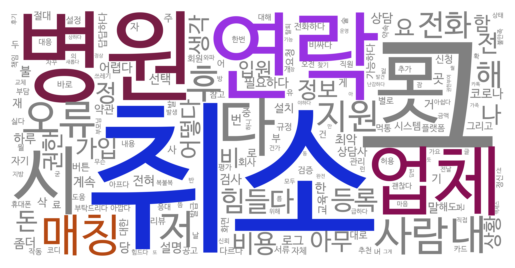

In [671]:
highlighted_words = ['취소', '연락', '병원', '환자', '매칭', '업체']
import random

def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in highlighted_words:
        hue = random.randint(0, 360)
        saturation = random.randint(50, 100)
        lightness = random.randint(20, 80)
        return "hsl({}, {}%, {}%)".format(hue, saturation, lightness)  # 랜덤 색상
    else:
        return "gray"  # 회색
        
wordCloud = WordCloud(scale=10, color_func=custom_color_func, background_color="white",
                     font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
wordCloud.generate_from_frequencies(text_split_count_02)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()


###### 부정 - 별점 1 & 2 점 리뷰 topic
- Topic 0: 답답하다, 오류, 연락, 추천, 어렵다, 전화하다, 전화, 설정, 금액, 간호사
- Topic 1: 필요하다, 지원, 병원, 설치, 카드, 가입, 자꾸, 입원, 취소, 먹통
- Topic 2: 별로, 취소, 전화, 생각, 로그, 교육, 등록, 모두, 설명, 난감하다
- Topic 3: 힘들다, 사람, 최악, 정보, 작동, 먹통, 어렵다, 상담, 아프다, 검색
- Topic 4: 매칭, 전혀, 계속, 무난, 취소, 병원, 저렴하다, 업체, 나쁘다, 사람

주목할 keyword : 취소, 연락, 병원, 환자, 매칭, 업체

##### 3. 긍정 리뷰 keyword 추출 & keyword 중심 문맥 확인

###### 긍정 review 
- 주목할 keyword : 후기, 정보, 선택, 도움, 친절, 추천, 경력, 매칭, 필요

In [681]:
def keyword_contents_positive(text):
    total_lists = df_appreview_okt.query('user_score == "4" or user_score == "5"')['user_comments']
    filter = []
    for total_list in total_lists:
        try:
            if text in total_list:
                total_list = str(total_list)
                print(total_list)
                print("--------")
            else : 
                pass
        except:
            print(total_list)
            pass

In [682]:
keyword_contents_positive('후기')

처음으로 간병 서비스 앱을 이용해봤는데 이렇게 고맙기는 처음이네요. 업체에서 간병인을 관리하는 건 아닌것같지만 후기를 직접 볼수있으니까 상대적으로 좋은 간병인을 만날 확률이 훨씬 높은 것 같아요. 후기 좋으신 분으로 선택했는데 왜 그런 후기를 받았는지 알겠어요. 경력도 있으셔서 꼼꼼하시고 배려심이 많은 분이에요. 정말 만족합니다.
--------
간병인 구할때 한번에 좋은 간병인 구하는게 진짜 쉬운일이 아니에요. 저도 간병인을 여러번 바꿨어요.한번씩 바꿀때마다 얼마나 번거롭고 짜증나던지. 이 어플을 쓰고 나서부터는 딱 한번 바꿨어요. 처음부터 제가 원하는 간병인을 선택할수 있어서 크게 바꿀일도 없었고 간병이 끝나면 좋은 후기 부탁한다고 더 정성껏 보살펴주시더라구요. 아주 만족합니다^^
--------
타 어플도 마찬가지지만 중개플랫폼이기 때문에 검증된 간병인을 기대하기는 힘들 것 같습니다. 하지만 후기라던지 별점 등을 보고 선택할 수 있으니 선택에 도움이 되었습니다~
--------
케어네이션 앱에서 후기 좋으신 간병인분으로 선택했는데 꼼꼼하게 잘 케어해주셨네요
--------
경력이나 후기를 보고 직접 선택하니까 믿을수 있고 간병인분도 친절했어요
--------
처음 간병인이 필요해서 여기저기 알아보는데 최근에 뉴스같은데 논란도 자주되고 그래서 걱정이 많았습니다. 협회나 이런데는 정보도없고 보내주는 사람만 믿어야되서 여기저기 찾아보는데, 간병인도 앱으로 고용할 수 있는걸 보고 고심하던중 케어네이션을 골랐습니다. 간병인분들의 프로필이나 후기를 확인할 수 있어서 너무 좋았고, 좋은분이 와주셔서 참 좋은 기억만 있습니다. 주변에도 필요한 사람이 있으면 추천드릴게요^^
--------
친구한테 추천받아 사용해봤는데요 일일이 업체한테 전화안해도 되어서 그점은 참 편리한 것 같아요 여러 어플이 있어 고민이 많이 되었는데 가장 후기가 좋아서 선택했습니다
--------
어플 특성상 전문적이고 확실한 간병인을 찾기 어려움이 있습니다. 그래도 후기나 프로필이 있으니 믿고 선

In [683]:
keyword_contents_positive('정보')

알찬 정보를 제공해 주셔서 참으로 감사합니다~^^~
--------
확실히 간병인업체에 전화로 구했던것보다는 많이 편해진거 같애요! 간병인정보도 핸드폰으로 다 확인할 수 있고 비교하면서 선택할수 있으니까 세상이 많이 변했네요.
--------
지인을통해 정보를알고 이용을 했습니다... 간병하시는분도 간병받는 저 또한 모두 만족했답니다... 참 편리하고 좋은 어플입니다... 많이 이용하세요~~^^
--------
처음 간병인이 필요해서 여기저기 알아보는데 최근에 뉴스같은데 논란도 자주되고 그래서 걱정이 많았습니다. 협회나 이런데는 정보도없고 보내주는 사람만 믿어야되서 여기저기 찾아보는데, 간병인도 앱으로 고용할 수 있는걸 보고 고심하던중 케어네이션을 골랐습니다. 간병인분들의 프로필이나 후기를 확인할 수 있어서 너무 좋았고, 좋은분이 와주셔서 참 좋은 기억만 있습니다. 주변에도 필요한 사람이 있으면 추천드릴게요^^
--------
카페에서 정보 얻고 간병인을 어플로도 구할수있다는걸 알았네요 ㅎㅎ 그래서 여러개 깔아보고 비교해서 결국 여기 선택했는데 오신 간병인 아주머니도 마음에 들고 여러모로 다음에도 사용할만한 어플이었습니다~
--------
간병인의 정보를 알 수 있다는게 좀 획기적이었던 것 같아요! 예전에는 일일이 다 전화해야했는데 여기는 그냥 제가 핸드폰으로 보고 선택할수있으니 좋아요~~~
--------
간병인에 대한 정보를 미리 보는게 가능해서 훨씬 도움이 되네요. 요즘 이런 어플이 많은데 그 중에서는 가장 깔끔하고 좋은듯해요..
--------
간병인 구하고 커뮤니티도 봤는데, 영상이랑 포스팅까지 정보가 많아서 너무 큰 도움이 되었어요!! 감사해요!!
--------
간병인뿐만 아니라 어플에서 여러 정보 볼 수 있는 것도 만족스러워요 간병에 대한 지식이 별로 없었는데 열심히 공부하고 있습니다!!
--------
환자 정보 입력하는게 조금 귀찮았는데 한번 작성하니까 재등록도 되고 편하네요 꼼꼼하게 간병인 구할 수 있어서 만족합니다
--------
아버지가

In [684]:
keyword_contents_positive('선택')

간병인 쓸일이 생겨서 검색 조금 하다가 전화해서 상담받았는데 그비싼 간병비를 현금으로만 받는다더라구요ㅠㅠ 너무 부담되서 다시 찾아보다가 케어네이션은 카드는 물론 할부까지 된다고 해서 바로 간병인 선택해서 잘 케어 받았습니다. 장기 간병인을 써야하는 저한테는 너무 좋네요.
--------
이전에는 그냥 매칭해주시는 분께 맡겼는데요, 앱에서는 간병 지원하신 분들 중 선택이 가능하다는게 너무 좋네요.
--------
급하게 간병인을 알아보다가 검색해보니 케어네이션이 유명하더라구요. 그래서 다운받아서 사용해보니까 제가 직접 간병인을 선택할수 있어서 너무 좋았고,다행히 잘 케어받았습니다. 감사합니다.
--------
원하는 일형태를 제가 직접 확인하고 선택할수있는 부분이 아주 마음에 듭니다.
--------
계속해서 보호자인 제게 연락 주시고 너무 책임감 넘치는 간병인님 만날 수 있었어요~평가 확인하구 선택할 수 있기 때문이 아닐까요
--------
원하는 날짜, 지역, 환자를 자유롭게 선택할수있어서 좋았습니다
--------
다른 간병업체 광고는 못본거 같은데 우연히 차승원 배우가 광고하는걸 보게 되어 이용해봤습니다. 가입부터 간병인 선택까지 너무 간단했고 카드결제라 비용적인 부담도 덜했네요~ 역시 차승원 배우가 괜히 선택한게 아니겠죠??^^
--------
처음으로 간병 서비스 앱을 이용해봤는데 이렇게 고맙기는 처음이네요. 업체에서 간병인을 관리하는 건 아닌것같지만 후기를 직접 볼수있으니까 상대적으로 좋은 간병인을 만날 확률이 훨씬 높은 것 같아요. 후기 좋으신 분으로 선택했는데 왜 그런 후기를 받았는지 알겠어요. 경력도 있으셔서 꼼꼼하시고 배려심이 많은 분이에요. 정말 만족합니다.
--------
여기서 간병인 구했다는 지인말듣고 한번 이용해봤는데 괜찮은듯합니다. 제일 마음에 든 점은 직접 간병인 선택할수있다는 점. 예전에 간병인 구했을때는 전화로만 하고 그냥 시간 되는사람 보내주는 식이어서 별로였습니다.. 잘모를땐 그냥 전화해서 물어봤는데 친절하게 알려주신 상담

In [685]:
keyword_contents_positive('도움')

케어닥에서 내게 맞는 일자리를 찾을수 있을것같습니다 항상 필요하는 사람들에게 도움이 되는 좋은 일자리라고 봅니다 케어닥 감사하고 번창하시기 바랍니다
--------
환자의 상태를 작성하면 적절한 간병비를 제시하는데 그 부분이 금액 고려를할 때 도움이 많이 됐습니다.
--------
몇 시간 단위로도 간병이 가능해서 급할 때 많은 도움을 받았습니다.
--------
간병인은 구해야겠고,,, 간병비는 도무지 얼마인지 감이 안잡혔는데 진단명만 입력하면 예상 간병비 바로 계산이 되니 도움이 많이 되었습니다. 그후에 간병인 신청 했는데 얼마 안지나서 매칭 빨리 되서 좋았어요
--------
평생 간병인을 구할일이 없을꺼라 생각하면서 살았습니다. 그런데 불행은 정말 한순간에 다가오더군요. 아버지 건강이 급격히 안좋아지셔서 여러차례 수술을 하고 간병인이 필요한 상황이었습니다. 지인들에게 추천도 받아보고.. 여러 업체에 전화도 해봤지만 % 제맘에 드는 간병인을 찾기란 너무 어렵더라구요.. 그러다 간병인 어플이 있다는 소식을 접하게 되어 케어네이션의 도움을 받았는데.. 정말 저만큼이나 꼼꼼하고 정성껏 돌봐주시는 간병인분 만날수 있었습니다.. 정말 감사합니다..
--------
타 어플도 마찬가지지만 중개플랫폼이기 때문에 검증된 간병인을 기대하기는 힘들 것 같습니다. 하지만 후기라던지 별점 등을 보고 선택할 수 있으니 선택에 도움이 되었습니다~
--------
친구에게 추천받고 이용해봤는데.. 좋은 간병인 이모님과 매칭되었어요. 연세가 너무 높으시지 않은 분을 원했는데 마침 딱 지원해주셔서 선택했어요 :) 덕분에 엄마 간병 수월하게 마쳤습니다.. 평생 간병인 구할 일 없을줄 알았는데 정말 사람일 모르더라구요.. 좋은 서비스 만들어주셔서 감사합니다. 많은 도움이 되었어요!!
--------
간병인 구하는 어플 쳤을때 가장 유명한곳 선택했는데 많이 이용하는덴 이유가 있네요~ 간병인 관한 후기도 투명하게 올려져 있어서 믿음이 갔어요. 간병인 선택하고 구하는데 많은 도움 받았어요~ 굿

In [686]:
keyword_contents_positive('친절')

첨 이용하는 거라 반신반의했는데 넘 친절하시고 만족스러웠어요. 담에 또 이용하려구요!
--------
장기간병인 분으로 신청했는데 첨부터 끝까지 친절했고, 정성을 다해서 잘 케어해주십니다
--------
간병인분한테 원하는걸 말하면 귀찮은티 없이 잘 들어주시고 친절하세요
--------
여기서 간병인 구했다는 지인말듣고 한번 이용해봤는데 괜찮은듯합니다. 제일 마음에 든 점은 직접 간병인 선택할수있다는 점. 예전에 간병인 구했을때는 전화로만 하고 그냥 시간 되는사람 보내주는 식이어서 별로였습니다.. 잘모를땐 그냥 전화해서 물어봤는데 친절하게 알려주신 상담원분도 감사의 말씀을 표합니다!!
--------
경력이나 후기를 보고 직접 선택하니까 믿을수 있고 간병인분도 친절했어요
--------
건강검진 하러 가는게 뭐라고 이렇게 떨리고 무섭던지, 마침 케어네이션에 동행 서비스가 있다고 하여 바로 신청했고, 서비스 전담팀 분들도 매우 친절하게 서비스 설명 해주신덕에 검진부터 검진 이후, 아직 마취때문에 몽롱한 기분까지도 케어해주시는 케어메이트님 덕분에 잘 받고 왔습니다. 감사합니다.
--------
처음 이용해봤는데... 이용 방법이 어렵진 않았어요. 대신 확실히 하려고 고객센터에 몇번 전화해봤네요. 고객센터분이 친절하게 잘 설명해주셔서 안심하고 공고 올렸는데 좋은 분이 매칭되어 만족스럽습니다^^
--------
물론 간병을 잘해주는게 가장 중요하지만..이번에 오신분은 말수가 적으시고 좀 무뚝뚝하셨어요.. 다음에 또 이용하게 된다면 살갑고 친절하다는 리뷰가 있는 분으로 구해볼까 합니다..
--------
예전 아버지 편찮으실땐 일일이 업체에 전화해서 간병인을 구하기도 했고 불친절한 간병인들도 많았는데 확실히 어플로 구하니까 금방 구하기도 하고 원하는 간병인을 선택할 수 있어서 편리한거 같습니다
--------
중대병원에서 엄마가 입원하셨는데.. 제가 임신중이라서 간병을 못하게 되어 간병인을 구하게 되었습니다.. 병원에서는 간병인협회 종이를 주는데.. 전화로 구하기도 힘

In [687]:
keyword_contents_positive('추천')

함께 해줄 수 있는 사람이 있다는게 심적으로 부담을 덜어줬습니다. 동행 서비스 추천드려요.
--------
좋은 간병인분이 오셔서 나름 만족했습니다! 지인들한테 추천하려고요
--------
평생 간병인을 구할일이 없을꺼라 생각하면서 살았습니다. 그런데 불행은 정말 한순간에 다가오더군요. 아버지 건강이 급격히 안좋아지셔서 여러차례 수술을 하고 간병인이 필요한 상황이었습니다. 지인들에게 추천도 받아보고.. 여러 업체에 전화도 해봤지만 % 제맘에 드는 간병인을 찾기란 너무 어렵더라구요.. 그러다 간병인 어플이 있다는 소식을 접하게 되어 케어네이션의 도움을 받았는데.. 정말 저만큼이나 꼼꼼하고 정성껏 돌봐주시는 간병인분 만날수 있었습니다.. 정말 감사합니다..
--------
간병인 찾을 때, 환자 상태 입력하는 부분에서 세심하게 신경쓰는게 느껴져서 좋았는데요 아무나 추천해주는게 아니라 직접 간병인을 확인하고 선택하는게 좋았어요.. 의사소통도 잘되고 엄마가 너무 편안해하셨습니다 ㅠㅠ
--------
처음 간병인이 필요해서 여기저기 알아보는데 최근에 뉴스같은데 논란도 자주되고 그래서 걱정이 많았습니다. 협회나 이런데는 정보도없고 보내주는 사람만 믿어야되서 여기저기 찾아보는데, 간병인도 앱으로 고용할 수 있는걸 보고 고심하던중 케어네이션을 골랐습니다. 간병인분들의 프로필이나 후기를 확인할 수 있어서 너무 좋았고, 좋은분이 와주셔서 참 좋은 기억만 있습니다. 주변에도 필요한 사람이 있으면 추천드릴게요^^
--------
지인소개로 한번 써봤는데 생각보다 괜찮더라구요. 보호자와 간병인입장을 다 고려해서 만들었다는 느낌이 들어요. 쉽지 않을텐데 정말 잘 만들었어요. 적극추천합니다!!^^
--------
친구에게 추천받고 이용해봤는데.. 좋은 간병인 이모님과 매칭되었어요. 연세가 너무 높으시지 않은 분을 원했는데 마침 딱 지원해주셔서 선택했어요 :) 덕분에 엄마 간병 수월하게 마쳤습니다.. 평생 간병인 구할 일 없을줄 알았는데 정말 사람일 모르더라구요.. 좋은 서비스 만들어주셔

In [688]:
keyword_contents_positive('경력')

입주경력많음
--------
처음으로 간병 서비스 앱을 이용해봤는데 이렇게 고맙기는 처음이네요. 업체에서 간병인을 관리하는 건 아닌것같지만 후기를 직접 볼수있으니까 상대적으로 좋은 간병인을 만날 확률이 훨씬 높은 것 같아요. 후기 좋으신 분으로 선택했는데 왜 그런 후기를 받았는지 알겠어요. 경력도 있으셔서 꼼꼼하시고 배려심이 많은 분이에요. 정말 만족합니다.
--------
계속 쭉 연장하고 했을정도로 간병인 매칭이 좋은 분과 되어 정말 만족스러웠습니다!! 경력이 많지 않으신데도 환자를 생각하는 마음과 봉사정신이 대단하셨어요. 다음 번에도 이용할 일이 있으면 이용할 예정입니다!
--------
간병인을 처음 구해봐서 어디를 이용해야 할지 많이 헤멨는데 결국 케어네이션을 이용하게 되었습니다. 경력이 있는 간병인이 지원을 안해서 결국 신입을 뽑았는데 걱정을 많이 했어요ㅠ 그런데 생각외로 너무 투철하게 잘해주셔서 만족스러웠어요. 별점도 좋게 남겨드렸어요,
--------
경력이나 후기를 보고 직접 선택하니까 믿을수 있고 간병인분도 친절했어요
--------
여러번 간병인을 구해봤는데요. 확실히 어플로 구하는 게 더 편리합니다. 간병인은 환자 상태를 보고 지원하고, 보호자는 간병인의 경력을 보고 선택할 수 있으니 잡음이 덜할 수밖에요...
--------
저는 경력 많은 중국인 간병인분을 선택했어요. 한국에 오신지 오래 되셔서 소통에 어려움은 없었고 하지만 목소리가 조금 크셨습니다. 그거 말고는 너무 능숙하게 케어해주셔서 굉장히 만족스러웠네요!
--------
지원한 사람이 많이 없어서 경력 없는 분을 울며 겨자먹기로 선택했는데요 오히려 배우는 자세로 더 열심히 하시더라구요 굉장히 고마웟습니다
--------
어제부터 앱을 유심히 살폈습니다 진짜 지원하는 분들이 있는지 근데 경력도 괜찮고 후기도 좋으신 분들이 지원해주시더라구요 믿음 각
--------
간병인께서 보내주신 간병비용들이 차이가 너무 나요 ㅠㅠ 마음은 경력이 많은 분을 선택하고 싶지만 비용때문에 망설이게 

In [689]:
keyword_contents_positive('매칭')

이전에는 그냥 매칭해주시는 분께 맡겼는데요, 앱에서는 간병 지원하신 분들 중 선택이 가능하다는게 너무 좋네요.
--------
간병인은 구해야겠고,,, 간병비는 도무지 얼마인지 감이 안잡혔는데 진단명만 입력하면 예상 간병비 바로 계산이 되니 도움이 많이 되었습니다. 그후에 간병인 신청 했는데 얼마 안지나서 매칭 빨리 되서 좋았어요
--------
수술이 급하게 잡혀서 몇일동안 돌봐줄 간병인이 필요했는데 매칭이 빨리 되서 다행이였어요 케어도 잘 해주시구요
--------
간병인들 사이에서 단기는 안좋아한다해서 걱정했는데 매칭도 빠르고 덕분에 편하게 병원 생활 했습니다
--------
매칭이 잘되는 것 같아요, 구하기 편함
--------
계속 쭉 연장하고 했을정도로 간병인 매칭이 좋은 분과 되어 정말 만족스러웠습니다!! 경력이 많지 않으신데도 환자를 생각하는 마음과 봉사정신이 대단하셨어요. 다음 번에도 이용할 일이 있으면 이용할 예정입니다!
--------
앱 이용자가 다른 어플에 비해 많은 것 같아서 설치해봤습니다~~ 분이 지원해주셔서 한분 선택하고 매칭됐는데 마음이 따뜻한 분이셔서 잘 돌봐주시고 갔습니다. ㅎㅎ
--------
처음에는 어떻게 사용할지 몰라 헤멨지만.. 결과는 좋아서 만족합니다. 다만 간병인과 소통을 미리 할수있었으면 좋겠다는 아쉬움은 있었지만 그래도 좋은간병인이 매칭되어 다행입니다.
--------
처음 이용해봤는데... 이용 방법이 어렵진 않았어요. 대신 확실히 하려고 고객센터에 몇번 전화해봤네요. 고객센터분이 친절하게 잘 설명해주셔서 안심하고 공고 올렸는데 좋은 분이 매칭되어 만족스럽습니다^^
--------
간병인을 구한 건 이번이 처음이었어요. 뉴스에는 간병인 폭행이라던지..안 좋은 소식만 전해지고 코로나때문에 면회도 거의 못 가고 정말 불안했습니다. 그런데 매칭된 간병인분이 매번 사진을 찍어 보내주셨는데 아버님 표정이 정말 좋으시더라구요. 덕분에 안심할 수 있었어요. 좋은 간병인분들도 많다는 걸 이번 기회에 느꼈네요
--------

In [690]:
keyword_contents_positive('필요')

일을 하며 필요한 관련 자료들을 쉽게 접할 수 있어 좋았습니다.
--------
케어닥에서 내게 맞는 일자리를 찾을수 있을것같습니다 항상 필요하는 사람들에게 도움이 되는 좋은 일자리라고 봅니다 케어닥 감사하고 번창하시기 바랍니다
--------
꼭 필요한 앱이라서 넘 조아요 가족중에 병원에 입원하면 정말 난감한데ㅡ 유용하게 사용하겠습니다
--------
수술이 급하게 잡혀서 몇일동안 돌봐줄 간병인이 필요했는데 매칭이 빨리 되서 다행이였어요 케어도 잘 해주시구요
--------
간병인만 구하는 걸로 알고 이용했었는데, 다른 서비스들고 생겼더라구요 필요하게 되면 이용해보려고해요 모델 차승원도 제가 넘 좋아하는 모델이라 이미지가 더 좋게 다가오는 거 같아요
--------
평생 간병인을 구할일이 없을꺼라 생각하면서 살았습니다. 그런데 불행은 정말 한순간에 다가오더군요. 아버지 건강이 급격히 안좋아지셔서 여러차례 수술을 하고 간병인이 필요한 상황이었습니다. 지인들에게 추천도 받아보고.. 여러 업체에 전화도 해봤지만 % 제맘에 드는 간병인을 찾기란 너무 어렵더라구요.. 그러다 간병인 어플이 있다는 소식을 접하게 되어 케어네이션의 도움을 받았는데.. 정말 저만큼이나 꼼꼼하고 정성껏 돌봐주시는 간병인분 만날수 있었습니다.. 정말 감사합니다..
--------
간병인비용 현금으로만 드려서 그냥 없어지는 돈이라 생각했었는데 케어네이션은 카드결제가 되서 너무 좋아요.저희는 길게 간병이 필요해서 간병비만 나가는돈이 만만치 않았거든요ㅠㅠ 이젠 간병비도 지출로 계산이 되니까 너무 다행이에요. 앱개발자님~ 너무 잘 만드셨어요. 대박나세요!
--------
처음 간병인이 필요해서 여기저기 알아보는데 최근에 뉴스같은데 논란도 자주되고 그래서 걱정이 많았습니다. 협회나 이런데는 정보도없고 보내주는 사람만 믿어야되서 여기저기 찾아보는데, 간병인도 앱으로 고용할 수 있는걸 보고 고심하던중 케어네이션을 골랐습니다. 간병인분들의 프로필이나 후기를 확인할 수 있어서 너무 좋았고, 좋은분이 와주셔서 

##### 4. 부정 리뷰 keyword 추출 (pain point) & keyword 중심 문맥 확인

###### 부정 review 
- 주목할 keyword : 취소, 연락, 병원, 환자, 매칭, 업체

In [692]:
def keyword_contents_negative(text):
    total_lists = df_appreview_okt.query('user_score == "1" or user_score == "2"')['user_comments']
    filter = []
    for total_list in total_lists:
        try:
            if text in total_list:
                total_list = str(total_list)
                print(total_list)
                print("--------")
            else : 
                pass
        except:
            print(total_list)
            pass

In [693]:
keyword_contents_negative('취소')

저도, 하루 간병, / 오전 시부터~ / 오전 시까지 , 하루 간병인이 필요해서, 간병인 구인을 일주일전에 하고, 간병인 지원자가 있어, 선택하고, 월일 결제했습니다 간병인이 월일 오전 시분에 온다고 했는데, 하루전, 월 일 오전 시 분에 간병인 전화와서 취소한다고 , 참, 황당하네요 고객센타 항의했는데, 간병인 취소하면, 자기들도(카네이션) 어떻게 할수가 없다고, 내일인데, 다시, 재등록 하라고, 다른데도 알아보라구, 어처구니가 없네요, 이것때문에 , 내일, 모든게 엉망이됬는데 . . . . . 하루동안에 , 어디서 어떻게 간병인을 구해야할지, 참 난감하네요 전날이나, 당일날, ( 간병인이 약속을 취소하거나, 않오면)이런문제가 발생하면, 환자 가족이 피해를 봅니다, 속수무책 예요 , 그래서, 결국에는, 간병인을 못 구했습니다, 저는, 다시는, 여기서(카네이션) 간병인 구인 않합니다 비추천예요
--------
간병인 교육이나 관리가 전혀 안되어있는곳.. 간병인 중 아무리 리뷰가 좋은 사람이 있다 하더라도 절대 그거 다 믿으면 안됩니다. 자기 감정 컨트롤 못하고 상식없고 수준이하인 사람 있어요.. 저는 매칭 이후 간병도 받기 전에 무례한 언행하는 문자들 연달아 받고 매칭 취소했습니다.
--------
일방적인 직전 취소시 보상규정 마련바랍니다. 간병시작 직전에 케어네이션으로부터 간병인 문제를 이유로 일방적으로 취소당했습니다. 그후 단기간에 다시 구하기도 힘들고 지원하신분도 요금을 높게 부르더군요. 거래는 케어네이션과 하는데 간병인 문제라고 뒤로 빠지는 것은 무책임한 대응입니다. 새로운 분을 구해주시던 차액을 보상해 주시던 대응책 마련 부탁드립니다. 그냥 병원에서 소개받는 것 대비 merit이 없습니다.
--------
월요일부터 간병인 오기로 해서 카드결제까지 했는데 갑자기 간병인이 일요일에 취소했고, 고객센터는 연락도 안됩니다 이런 서비스정신 엉터리입니다 불편해서 어디 이용할 수 있나요? 소비자를 고려하지 않고 자신들의 편의만 생각하는 자세라 생각됩니다 이용하

In [694]:
keyword_contents_negative('연락')

궁금한게 이 어플이 왜 내연락처. 사진과동영상 그리고 그외 내폰에 액세스하는 권한부여 요청을 해야만 사용이 가능하도록 되어있던데 최소한 그 액세스 권한부여가 왜필요한것들인지에 대한 설명은 되어야하지 않을까요? 어플의 어떤 기능때문에 액세스 권한을 부여해야하는지를 알려줘야죠. 굳이 필요없을 것 같은 권한까지 요청하며 설명없이 권한부여를히지 않으면 이용조차못하도록 막는게 좀 꺼림칙하네요. 그리고 마케팅으로 활용할 개인 정보를 선택이 아닌 강제 동의를 하도록 해놓으신거가요? 환자의 건강정보와 개인정보는 간병인과의 매칭에만 이용하고 폐기해야죠. 개인정보활용에 너무 안일하고 소홀한 어플이 아닌가 싶네요.
--------
간병비 결제하기 전에 간병인과 한번쯤 연락할 수 있었으면 좋겠네요~ 그 부분이 조금 아쉬워요. 매칭된 분은 괜찮은 것 같아요..
--------
월요일부터 간병인 오기로 해서 카드결제까지 했는데 갑자기 간병인이 일요일에 취소했고, 고객센터는 연락도 안됩니다 이런 서비스정신 엉터리입니다 불편해서 어디 이용할 수 있나요? 소비자를 고려하지 않고 자신들의 편의만 생각하는 자세라 생각됩니다 이용하시려는 분들 참고하세요 연락이 잘 안됩니다. 불편합니다 별하나도 아깝네요
--------
매칭되어 결제하고 간병인에 연락하니 병원이 어딘지 물어보더니 멀어서 못간다고 하네요. 공고에 병원명과 주소를 등록해놨는데 매칭은 무작위로 해놓고 보호자가 다시 확인하도록 하니 서비스에 대한 신뢰가 어렵고 매우 불편하게 합니다.
--------
간병비 결제 전에 간병인이랑 연락해보고 싶은데 채팅 기능이라도 만들어줫음 좋겠어요
--------
주간만 구하려고 하는데 환자정보에는 시간대 설정이 없고 간병인과 연락이 안되니 커뮤니케이션도 불가능하고??? 조건을 제대로 올리지도 못하게해두고 선결제 해야만 연락할 수 있게 하니 너무 답답하네요. 다른앱은 일별 시간대 선택 가능한데 서비스가능지역이 아니고 휴;;;
--------
당장 다음날 급히 간병인이 필요해서 앱 처음 이용했습니다. :에 

In [695]:
keyword_contents_negative('병원')

업그레이드될수록 맘에 안듭니다!!간병비도 넘 싸고 지역별로 나누고 병원,재가도 나눠서 보여줬음 좋겠네요!!😠😠😠👊👊👊👊👊
--------
일방적인 직전 취소시 보상규정 마련바랍니다. 간병시작 직전에 케어네이션으로부터 간병인 문제를 이유로 일방적으로 취소당했습니다. 그후 단기간에 다시 구하기도 힘들고 지원하신분도 요금을 높게 부르더군요. 거래는 케어네이션과 하는데 간병인 문제라고 뒤로 빠지는 것은 무책임한 대응입니다. 새로운 분을 구해주시던 차액을 보상해 주시던 대응책 마련 부탁드립니다. 그냥 병원에서 소개받는 것 대비 merit이 없습니다.
--------
일주일 병원 간병 신청했는데 입원일까지 지원자가 없어 병원에서 구했습니다. 앱 자체는 괜찮던데아쉽네요.
--------
매칭되어 결제하고 간병인에 연락하니 병원이 어딘지 물어보더니 멀어서 못간다고 하네요. 공고에 병원명과 주소를 등록해놨는데 매칭은 무작위로 해놓고 보호자가 다시 확인하도록 하니 서비스에 대한 신뢰가 어렵고 매우 불편하게 합니다.
--------
서울대병원에서 뇌출혈 수술하고 간병인이 필요했는데 덕분에 잘 구햇습니다
--------
이 앱 사용하시는 분들 이거 꼭 참고하시길 바랍니다. 간병인 코로나검사 비용을 보호자에게 청구하는 약관이 상식적으로 맞다고 보십니까? 케어네이션의 약관이 잘못된것 같습니다. 케어네이션 약관에 간병인 코로나검사 비용을 보호자가 부담하라고 나와 있다고 코로나검사를 굳이 병원에서 비싸게 받고 청구하는게 말이나 됩니까? 케어네이션 약관자체가 보호자가 코로나검사 비용을 부담하게 해놔서 간병인이 병원에서 돈내고 검사해서 보호자한테 비용 청구하면 내줘야한답니다. 이걸 악용하는 간병인도 있을텐데.. 무료인 보건소에서 안하고 굳이 병원에서 하는 분들요. 간병인이 병원에서 일하길 원하면 코로나 검사를 받는 당사자가 비용 부담해서 받는게 당연한거고 그게 싫으면 보건소에서 무료검사를 해야지, 어찌 그것을 보호자가 모두 부담하게 해놨는지 케어네이션 약관이 잘못된것 같다고 수정요청부탁드리니

In [696]:
keyword_contents_negative('환자')

저도, 하루 간병, / 오전 시부터~ / 오전 시까지 , 하루 간병인이 필요해서, 간병인 구인을 일주일전에 하고, 간병인 지원자가 있어, 선택하고, 월일 결제했습니다 간병인이 월일 오전 시분에 온다고 했는데, 하루전, 월 일 오전 시 분에 간병인 전화와서 취소한다고 , 참, 황당하네요 고객센타 항의했는데, 간병인 취소하면, 자기들도(카네이션) 어떻게 할수가 없다고, 내일인데, 다시, 재등록 하라고, 다른데도 알아보라구, 어처구니가 없네요, 이것때문에 , 내일, 모든게 엉망이됬는데 . . . . . 하루동안에 , 어디서 어떻게 간병인을 구해야할지, 참 난감하네요 전날이나, 당일날, ( 간병인이 약속을 취소하거나, 않오면)이런문제가 발생하면, 환자 가족이 피해를 봅니다, 속수무책 예요 , 그래서, 결국에는, 간병인을 못 구했습니다, 저는, 다시는, 여기서(카네이션) 간병인 구인 않합니다 비추천예요
--------
궁금한게 이 어플이 왜 내연락처. 사진과동영상 그리고 그외 내폰에 액세스하는 권한부여 요청을 해야만 사용이 가능하도록 되어있던데 최소한 그 액세스 권한부여가 왜필요한것들인지에 대한 설명은 되어야하지 않을까요? 어플의 어떤 기능때문에 액세스 권한을 부여해야하는지를 알려줘야죠. 굳이 필요없을 것 같은 권한까지 요청하며 설명없이 권한부여를히지 않으면 이용조차못하도록 막는게 좀 꺼림칙하네요. 그리고 마케팅으로 활용할 개인 정보를 선택이 아닌 강제 동의를 하도록 해놓으신거가요? 환자의 건강정보와 개인정보는 간병인과의 매칭에만 이용하고 폐기해야죠. 개인정보활용에 너무 안일하고 소홀한 어플이 아닌가 싶네요.
--------
어플 네트워크 연결안된다 가끔 뜨지만 뭐 그렇다 이해합니다. 어려울때 많은 도움이 되었지만... 간병인.... 참 할많하않입니다. 검증된 간병인이 지원하는지 알 수는 없지만 개 ** 욕 나옵니다. 처방전 약 챙겨가거나 지 맘대로 조절하거나 참 왜 간병인을 하는지... 환자 침대에 다리올리고 정신 멀쩡한 환자 항의하니 뭔 정신병자 취급하고... 간병

In [697]:
keyword_contents_negative('매칭')

넘 매칭이안되요모든정보다주었는데그래서짜증나서삭제했어요
--------
매칭이 전혀 없네요 아쉽네요
--------
궁금한게 이 어플이 왜 내연락처. 사진과동영상 그리고 그외 내폰에 액세스하는 권한부여 요청을 해야만 사용이 가능하도록 되어있던데 최소한 그 액세스 권한부여가 왜필요한것들인지에 대한 설명은 되어야하지 않을까요? 어플의 어떤 기능때문에 액세스 권한을 부여해야하는지를 알려줘야죠. 굳이 필요없을 것 같은 권한까지 요청하며 설명없이 권한부여를히지 않으면 이용조차못하도록 막는게 좀 꺼림칙하네요. 그리고 마케팅으로 활용할 개인 정보를 선택이 아닌 강제 동의를 하도록 해놓으신거가요? 환자의 건강정보와 개인정보는 간병인과의 매칭에만 이용하고 폐기해야죠. 개인정보활용에 너무 안일하고 소홀한 어플이 아닌가 싶네요.
--------
간병비 결제하기 전에 간병인과 한번쯤 연락할 수 있었으면 좋겠네요~ 그 부분이 조금 아쉬워요. 매칭된 분은 괜찮은 것 같아요..
--------
간병인 교육이나 관리가 전혀 안되어있는곳.. 간병인 중 아무리 리뷰가 좋은 사람이 있다 하더라도 절대 그거 다 믿으면 안됩니다. 자기 감정 컨트롤 못하고 상식없고 수준이하인 사람 있어요.. 저는 매칭 이후 간병도 받기 전에 무례한 언행하는 문자들 연달아 받고 매칭 취소했습니다.
--------
매칭되어 결제하고 간병인에 연락하니 병원이 어딘지 물어보더니 멀어서 못간다고 하네요. 공고에 병원명과 주소를 등록해놨는데 매칭은 무작위로 해놓고 보호자가 다시 확인하도록 하니 서비스에 대한 신뢰가 어렵고 매우 불편하게 합니다.
--------
제발제발제발 이 앱 깔지마세요.. 간병인이 약속시간 분후에 아무런 말도 없이 갑작스레 취소를 해도 고객센터에서 도 해주는게 없습니다. 자기들의 직원이 아니라고, 프리랜서로 일하는 일반인들이라고, 아무 정보도 모른다고 하네요ㅋㅋㅋㅋㅋㅋㅋㅋㅋ 막말로 범죄자도 아무런 제약없이 일 할 수 있다는 소리입니다. 정말 속터져서 죽을뻔했어요 울면서 다음 간병인 매칭하고 오늘내일 있던 

In [698]:
keyword_contents_negative('업체')

제대로 검증 안된 간병인 들이 많습니다. 시간약속도 안지키고 일방적으로 귀가하고 너무나도 돈도 아깝고 엉망이네요. 그리고 앱 안정성 및 UI/UX 개판이고 차라리 케어닥이 훨씬 저렴하고 연계되어있는 업체도 많습니다. 앱지우고 케어닥으로 넘어가겠습니다.
--------
간병인이 오기전날 오후 열시에 못온다고 연락이 와서 많이 곤란했습니다. 간병인 관리가 안되는 업체는 반성핫니ㅣ요
--------
카드결제 되고, 지원하는 사람들이 많다는 것 빼고는 그냥 간병업체와 비슷함
--------
요기 간병인 요청해서 애들엄마 간병했는데 그지같은 간병사와서 잠만자고 협착으로 수술회복하고 있는데 간병인이 감기걸려서 횐자에게 옴기고 업체에 뭐라고 했더니 간병인에게 주의준게 다고 간병인은 환자가 화장실에서 볼일본사이 혼자 병실와서 환자 혼자 병실오게 만들고 이런분이있는 이런곳에서 간병인 구하고 싶나요 돈이 아깝습니다. 리뷰가 좋아서 한번 해봤는데 실망만 하고
--------
업체는 연결해주는 플랫폼이라고 간병인 태도에 대한 책임은 없다고 함. 교육같은 게 따로 없는듯ㅎ
--------
최악 융통성이라곤 제로이고 상황이나 본인들이 동의한결과인데 인정안함 환자가 더 힘들거에요 비추비추 완전비추 환자힘들게할거아니면 어플 사용 비추 그냥 병원에서 안내해주는 간병업체이용 추천!!간병인 의견 묵살하는 어플이고 플렛폼임
--------
최악의 업체
--------
약속한 기한 하루전에 코디님이 취소를 해버리고 케어닥도 그냥 취소 해버리고 취소한 코디님 리뷰는 남길수도 없고 어쩐지 코디님들 평이 다 좋은것만 있더라니 그냥 좋은 것만 남기게하고 나쁜건 지우시나보내요? 간절하고 힘든 환자와 보호자를 이용해서 이득만 취하려고하는 최악의 업체이네요 정말로 이게 선한 영향력을 끼치고 있다고 생각하는지 반성하시고 이 글 읽는 관계자와 직원분들 부끄러운줄 아세요
--------
한번 여기 써본사람들은 안쓰지. 최근 댓글만봐도 너무티나 아무리 간병인이 케바케라고 해도 그렇치.그럼 다른업체랑 다를게뭐냐고.근데